# **imports**

In [1]:
!nvidia-smi

Sat Oct  4 17:32:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.03                 Driver Version: 566.03         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
| 37%   45C    P0             30W /  165W |    1287MiB /  16380MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset

import torchvision
from torchvision import datasets
from torchvision import transforms as T
from torchvision.models import vit_b_16 as ViT
from torchvision.models import resnet34 as ResNet34
from torch.utils.data import Dataset
from torchvision.datasets.utils import download_url

import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import Accuracy
import os
from PIL import Image

import json

# **dataset**

In [4]:
def expand_if_grayscale(x):
    # 如果只有1個channel才expand
    if x.shape[0] == 1:
        return x.expand(3, -1, -1)
    return x

In [5]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Lambda(expand_if_grayscale),
    T.Normalize([0.1307], [0.3081])
])
train_data = datasets.EMNIST(root='EMNIST/raw/train-images-idx3-ubyte', split='balanced', train=True, transform=transforms, download=True)
test_data = datasets.EMNIST(root='EMNIST/raw/test-images-idx3-ubyte', split='balanced', train=False, transform=transforms, download=True)
class_number = 47

In [ ]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Lambda(expand_if_grayscale),
    T.Normalize([0.1307, 0.1307, 0.1307], [0.3081, 0.3081, 0.3081])
])
train_data = datasets.CIFAR100(root='CIFAR100', train=True, transform=transforms, download=True)
test_data = datasets.CIFAR100(root='CIFAR100', train=False, transform=transforms, download=True)
class_number = 100

In [ ]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

with open(r"C:\Users\User\Downloads\archive\Labels.json", 'r') as f:
    idx2label = json.load(f)

train_data = datasets.ImageFolder(root=r"C:\Users\User\Downloads\archive\train.X", transform=transform)
test_data = datasets.ImageFolder(root=r"C:\Users\User\Downloads\archive\val.X", transform=transform)
class_number = len(train_data.classes)

In [6]:
train_data.class_to_idx

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'A': 10,
 'B': 11,
 'C': 12,
 'D': 13,
 'E': 14,
 'F': 15,
 'G': 16,
 'H': 17,
 'I': 18,
 'J': 19,
 'K': 20,
 'L': 21,
 'M': 22,
 'N': 23,
 'O': 24,
 'P': 25,
 'Q': 26,
 'R': 27,
 'S': 28,
 'T': 29,
 'U': 30,
 'V': 31,
 'W': 32,
 'X': 33,
 'Y': 34,
 'Z': 35,
 'a': 36,
 'b': 37,
 'd': 38,
 'e': 39,
 'f': 40,
 'g': 41,
 'h': 42,
 'n': 43,
 'q': 44,
 'r': 45,
 't': 46}

In [7]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].


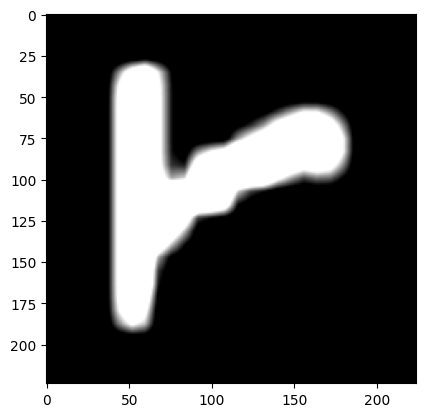

In [8]:
# 取出一個 batch，並取得第一個資料
x, y = next(iter(train_loader))
plt.imshow(x[0].permute(1, 2, 0))

# **ResNet Model**

In [9]:
model = ResNet34(weights=None)
model.fc = nn.Linear(512, class_number)
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.layer4[0]

BasicBlock(
  (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

# **ViT model**

In [ ]:
model = ViT(weights=None)
model.heads.head = nn.Linear(model.heads.head.in_features, class_number)

# **Optimizer**

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [12]:
loss_fn = nn.CrossEntropyLoss()

# **Train**

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

class AverageMeter(object) :
  def __init__(self):
    self.reset()
  def reset(self) :
    self.avg = 0
    self.val = 0
    self.sum = 0
    self.count = 0
  def update (self, val, n=1) :
    self.val = val
    self.count += n
    self.sum += self.val * n
    self.avg = self.sum / self.count

def train(model, train_loader, optimizer, loss_fn, epoch=None):
  model.train()
  trian_loss = AverageMeter()
  train_acc = Accuracy(task='multiclass', num_classes=class_number).to(device)
  with tqdm(train_loader, unit='batch') as tepoch :
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      trian_loss.update(loss.item())
      train_acc(outputs.argmax(dim=1), targets)

      tepoch.set_postfix(loss=trian_loss.avg,
                         accuracy=100*train_acc.compute().item())
    return model, trian_loss.avg, train_acc.compute()

def evaluate (model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    test_loss = AverageMeter()
    test_acc = Accuracy(task='multiclass', num_classes=class_number).to(device)
    for n, (inputs, targets) in enumerate(test_loader):
      inputs =  inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      test_loss.update(loss)
      test_acc(outputs, targets)
      return test_loss.avg, test_acc.compute()
    

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

In [14]:
epoch_number = 15

for epoch in range(epoch_number):
  model, train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, epoch)

  test_loss, test_acc = evaluate(model, test_loader, loss_fn)
  loss_train_hist.append(train_loss)
  loss_valid_hist.append(test_loss.to('cpu'))

  acc_train_hist.append(train_acc.to('cpu'))
  acc_valid_hist.append(test_acc.to('cpu'))
  print(f'Test - Loss:{test_loss} - Accuracy:{test_acc}')
  print()

Epoch 0: 100%|██████████| 882/882 [06:21<00:00,  2.31batch/s, accuracy=81.4, loss=0.604]


Test - Loss:0.3975251019001007 - Accuracy:0.8515625



Epoch 1: 100%|██████████| 882/882 [06:33<00:00,  2.24batch/s, accuracy=88.4, loss=0.316]


Test - Loss:0.41496190428733826 - Accuracy:0.84375



Epoch 2: 100%|██████████| 882/882 [06:31<00:00,  2.25batch/s, accuracy=89.3, loss=0.288]


Test - Loss:0.4455481767654419 - Accuracy:0.859375



Epoch 3: 100%|██████████| 882/882 [06:29<00:00,  2.26batch/s, accuracy=89.8, loss=0.272]


Test - Loss:0.35801494121551514 - Accuracy:0.8984375



Epoch 4: 100%|██████████| 882/882 [06:29<00:00,  2.26batch/s, accuracy=90.1, loss=0.261]


Test - Loss:0.3849703371524811 - Accuracy:0.875



Epoch 5: 100%|██████████| 882/882 [06:28<00:00,  2.27batch/s, accuracy=90.4, loss=0.252]


Test - Loss:0.3593541085720062 - Accuracy:0.875



Epoch 6: 100%|██████████| 882/882 [06:39<00:00,  2.21batch/s, accuracy=90.8, loss=0.24] 


Test - Loss:0.3436528742313385 - Accuracy:0.890625



Epoch 7: 100%|██████████| 882/882 [06:30<00:00,  2.26batch/s, accuracy=91, loss=0.235]  


Test - Loss:0.40431591868400574 - Accuracy:0.875



Epoch 8: 100%|██████████| 882/882 [06:27<00:00,  2.28batch/s, accuracy=91.4, loss=0.226]


Test - Loss:0.3489440977573395 - Accuracy:0.90625



Epoch 9: 100%|██████████| 882/882 [06:29<00:00,  2.26batch/s, accuracy=91.5, loss=0.219]


Test - Loss:0.35228657722473145 - Accuracy:0.8828125



Epoch 10: 100%|██████████| 882/882 [06:23<00:00,  2.30batch/s, accuracy=91.8, loss=0.209]


Test - Loss:0.2861923575401306 - Accuracy:0.90625



Epoch 11: 100%|██████████| 882/882 [06:30<00:00,  2.26batch/s, accuracy=92.1, loss=0.199]


Test - Loss:0.23576639592647552 - Accuracy:0.9140625



Epoch 12: 100%|██████████| 882/882 [06:26<00:00,  2.28batch/s, accuracy=92.4, loss=0.19] 


Test - Loss:0.2414294332265854 - Accuracy:0.9375



Epoch 13: 100%|██████████| 882/882 [06:27<00:00,  2.28batch/s, accuracy=93, loss=0.176]  


Test - Loss:0.33743974566459656 - Accuracy:0.8984375



Epoch 14: 100%|██████████| 882/882 [06:27<00:00,  2.28batch/s, accuracy=93.3, loss=0.166]


Test - Loss:0.3535608649253845 - Accuracy:0.875



# **Plot**

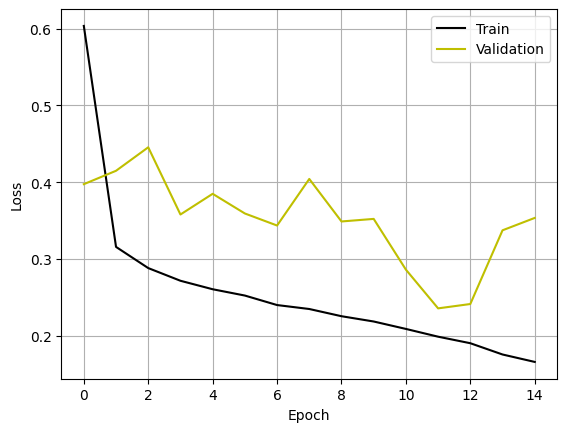

In [15]:
avg_epoch = 15
plt.plot(range(avg_epoch), loss_train_hist, 'k-', label="Train",)
plt.plot(range(avg_epoch), loss_valid_hist, 'y-', label="Validation")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

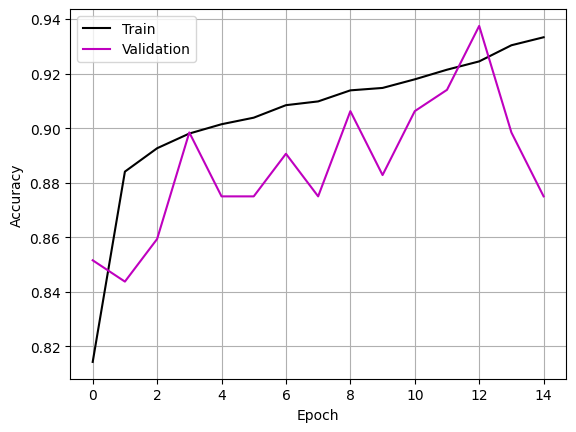

In [16]:
plt.plot(range(avg_epoch), acc_train_hist, 'k-', label='Train')
plt.plot(range(avg_epoch), acc_valid_hist, 'm-', label='Validation',)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

In [17]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
torch.save(model, 'C:\\Users\\User\\Documents\\GitHub\\Models-Build\\ResNet34-ImageNet-batchsize128-opt=SGD+lr=0.001.pth')